In [6]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [10]:
def plot_rgb_3d(image_path, sample_size=10000):
    # 打开图片并转换为 RGB 模式
    img = Image.open(image_path).convert("RGB")
    # 将图片转换为 numpy 数组
    img_array = np.array(img)
    # 获取图片的宽度和高度
    height, width, _ = img_array.shape
    # 将图片数据重塑为 (height * width, 3) 的二维数组
    pixels = img_array.reshape(-1, 3)

    # 随机采样（避免数据量过大）
    if len(pixels) > sample_size:
        indices = np.random.choice(len(pixels), sample_size, replace=False)
        pixels = pixels[indices]

    # 分离 RGB 通道
    r, g, b = pixels[:, 0], pixels[:, 1], pixels[:, 2]

    # 创建 3D 图
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(r, g, b, c=pixels / 255.0, marker='o', s=1)  # 颜色归一化到 [0, 1]

    # 设置坐标轴标签
    ax.set_xlabel('Red')
    ax.set_ylabel('Green')
    ax.set_zlabel('Blue')

    # 设置坐标轴范围
    ax.set_xlim(0, 255)
    ax.set_ylim(0, 255)
    ax.set_zlim(0, 255)

    # 显示图形
    plt.title("RGB Color Space 3D Plot")
    plt.show()


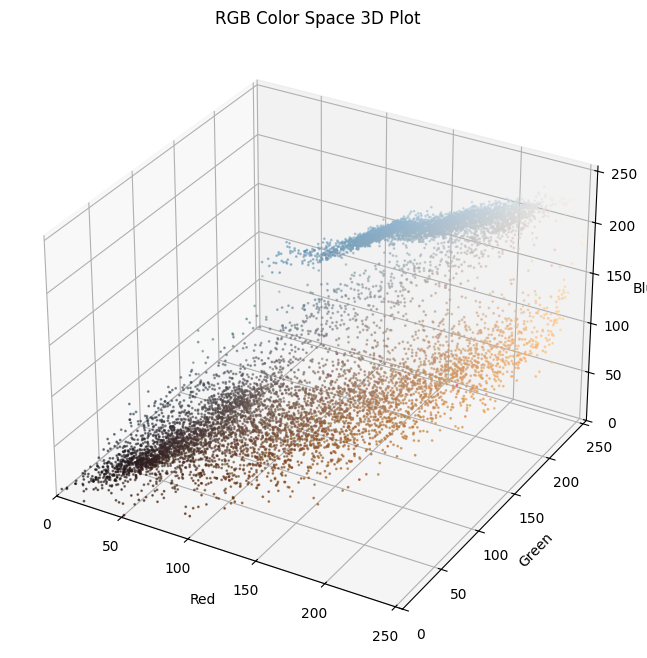

In [11]:
plot_rgb_3d("D:/胶片数据集/柯达金200/输出/digital_2.jpg", sample_size=10000)


In [1]:
from tensorwatch import draw_model
import torch
from torch import nn
from torchsummary import summary

In [3]:
# 通道注意力机制 (Channel Attention Mechanism)
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_channels // reduction, in_channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class FilmStyleTransfer(torch.nn.Module):
    def __init__(self):
        super(FilmStyleTransfer, self).__init__()

        # 定义卷积层
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = torch.nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv5 = torch.nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.conv6 = torch.nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.conv7 = torch.nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.conv8 = torch.nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1)
        
        # 定义激活函数
        self.leakyrelu = torch.nn.LeakyReLU()
        
        # 定义BatchNorm层
        self.bn1 = torch.nn.BatchNorm2d(32)
        self.bn2 = torch.nn.BatchNorm2d(64)
        self.bn3 = torch.nn.BatchNorm2d(128)
        self.bn4 = torch.nn.BatchNorm2d(256)
        self.bn5 = torch.nn.BatchNorm2d(128)
        self.bn6 = torch.nn.BatchNorm2d(64)
        self.bn7 = torch.nn.BatchNorm2d(32)

        # 注意力机制
        self.ca2 = ChannelAttention(64)
        self.ca3 = ChannelAttention(128)
        self.ca4 = ChannelAttention(256)
        self.ca5 = ChannelAttention(128)
        self.ca6 = ChannelAttention(64)
        self.ca7 = ChannelAttention(32)
        
        # 跳跃连接的卷积层
        self.skip1 = torch.nn.Conv2d(32, 3, kernel_size=1, stride=1, padding=0)  # 将32通道映射到3通道
        self.skip2 = torch.nn.Conv2d(64, 3, kernel_size=1, stride=1, padding=0)  # 将64通道映射到3通道
        
    def forward(self, x):
        x1 = (self.leakyrelu(self.bn1(self.conv1(x))))
        x2 = self.ca2(self.leakyrelu(self.bn2(self.conv2(x1))))
        x3 = self.ca3(self.leakyrelu(self.bn3(self.conv3(x2))))
        x4 = self.ca4(self.leakyrelu(self.bn4(self.conv4(x3))))
        x5 = self.ca5(self.leakyrelu(self.bn5(self.conv5(x4))))
        x6 = self.ca6(self.leakyrelu(self.bn6(self.conv6(x5))))
        x7 = self.ca7(self.leakyrelu(self.bn7(self.conv7(x6))))
        x8 = self.conv8(x7)
        
        # 跳跃连接
        skip1 = self.skip1(x1)  # 将x1的32通道映射到3通道
        skip2 = self.skip2(x2)  # 将x2的64通道映射到3通道
        
        # 合并跳跃连接和最终输出
        output = x8 + skip1 + skip2

        return output

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [5]:
other_pre_train_model = FilmStyleTransfer()
loss_function = torch.nn.SmoothL1Loss(reduction='mean')
pre_train_pre_epochs = 0

In [6]:
checkpoint = torch.load("./app/kodark_gold_200.pt", map_location=device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 恢复模型和优化器状态
other_pre_train_model.load_state_dict(checkpoint['model_state_dict'])
other_pre_train_model = other_pre_train_model.to(device)
other_pre_train_model.eval()
pre_train_pre_epochs = checkpoint['epoch']

# 恢复训练状态
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [7]:
print(other_pre_train_model)

FilmStyleTransfer(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (leakyrelu): LeakyReLU(negative_slope=0.01)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0

In [ ]:
summary(other_pre_train_model, (3, 200, 320))

TypeError: Value after * must be an iterable, not int